## Load the LWF Dataset

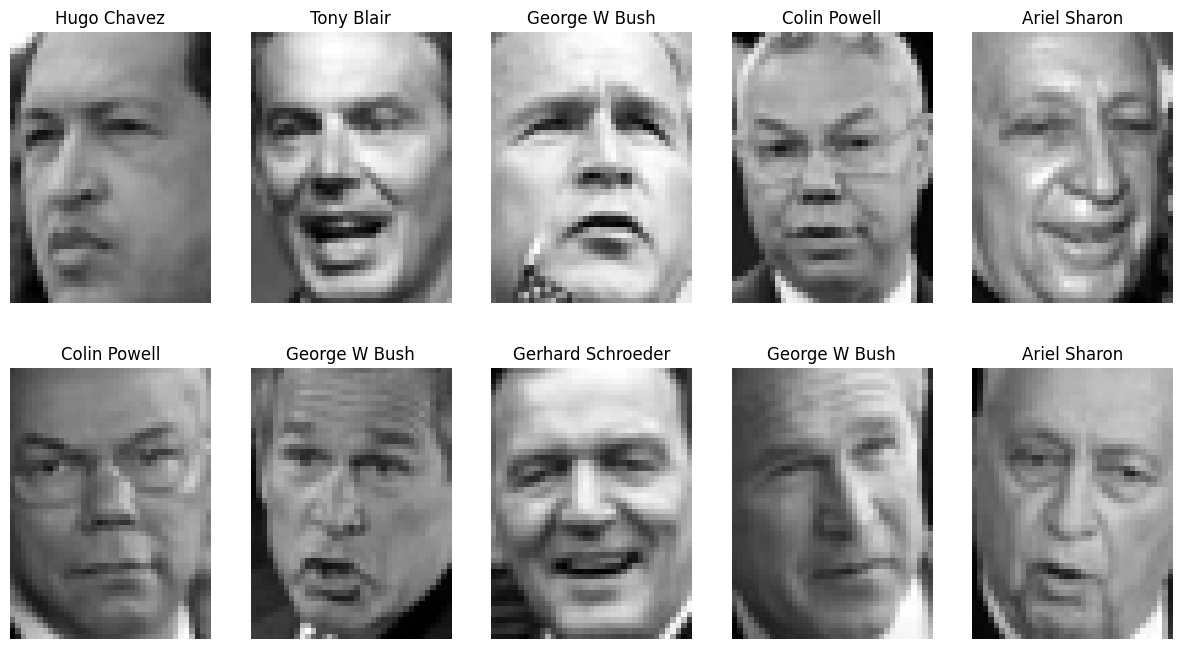

In [1]:
from sklearn.datasets import fetch_lfw_people
import matplotlib.pyplot as plt

# Download the LFW dataset
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# Access data
images = lfw_people.images
labels = lfw_people.target
target_names = lfw_people.target_names

# Showing the first 10 images
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(images[i], cmap='gray')
    ax.set_title(target_names[labels[i]])
    ax.axis('off')

plt.show()


## Save the images,labes and names

In [2]:
import pickle


# Save the data to a file
with open('Dataset\\lfw_people.pkl', 'wb') as f:
    pickle.dump(lfw_people, f)

# Save images, labels, and target names separately
images = lfw_people.images
labels = lfw_people.target
target_names = lfw_people.target_names

# Saving individual components in case we need them seperated
with open('Dataset\\lfw_images.pkl', 'wb') as f_img, open('Dataset\\lfw_labels.pkl', 'wb') as f_lbl, open('Dataset\\lfw_target_names.pkl', 'wb') as f_names:
    pickle.dump(images, f_img)
    pickle.dump(labels, f_lbl)
    pickle.dump(target_names, f_names)

print("LFW dataset saved successfully.")


LFW dataset saved successfully.


## Using ResNet50 for embedding

In [13]:
import pickle
import numpy as np
from PIL import Image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

In [14]:
# Load the dataset
with open('Dataset/lfw_images.pkl', 'rb') as f:
    lfw_images = pickle.load(f)

with open('Dataset/lfw_labels.pkl', 'rb') as f:
    lfw_labels = pickle.load(f)

with open('Dataset/lfw_target_names.pkl', 'rb') as f:
    lfw_names = pickle.load(f)


In [15]:
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
model = Model(inputs=base_model.input, outputs=base_model.output)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 104s 1us/step


In [16]:
def preprocess_image(img):
    img = Image.fromarray(img).convert('RGB')
    img = img.resize((224, 224))  # Resize to match ResNet50 input size
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array


In [17]:
embeddings_with_labels = []
for idx, img in enumerate(lfw_images):
    img_array = preprocess_image(img)
    
    # Generate embedding
    embedding = model.predict(img_array)
    label = lfw_labels[idx]
    name = lfw_names[label]
    embeddings_with_labels.append((embedding.flatten(), label, name))

# Save the embeddings with labels and names
with open('Dataset/lfw_embeddings_with_labels_names_resnet50.pkl', 'wb') as f:
    pickle.dump(embeddings_with_labels, f)

print("Embeddings, labels, and names saved successfully using ResNet50.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━

## Storing the embeddings to FAISS vector db

In [33]:
import pickle
import faiss
import numpy as np

In [34]:
# Load embeddings, labels, and names
with open('Dataset/lfw_embeddings_with_labels_names_resnet50.pkl', 'rb') as f:
    embeddings_with_labels_names = pickle.load(f)


In [35]:

# Extract embeddings, labels, and names
embeddings = np.array([item[0] for item in embeddings_with_labels_names])
labels = np.array([item[1] for item in embeddings_with_labels_names])
names = [item[2] for item in embeddings_with_labels_names]


In [36]:
# Normalize embeddings for cosine similarity
norms = np.linalg.norm(embeddings, axis=1, keepdims=True)
normalized_embeddings = embeddings / norms
# Initialize FAISS index for cosine similarity
dimension = normalized_embeddings.shape[1]  
index = faiss.IndexFlatIP(dimension) 


In [37]:
index.add(normalized_embeddings)


In [38]:
# Save the FAISS index to a file
faiss.write_index(index, 'Dataset/lfw_embeddings_index.faiss')


In [39]:
# Save labels and names separately
with open('Dataset/lfw_labels_for_index.pkl', 'wb') as f:
    pickle.dump(labels, f)

with open('Dataset/lfw_names_for_index.pkl', 'wb') as f:
    pickle.dump(names, f)

print("FAISS index, labels, and names saved successfully.")

FAISS index, labels, and names saved successfully.
